# MaxViT

In [ ]:
pip install timm

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import torch
import timm
import time
import numpy as np
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
# Path to your maize dataset
data_dir = '/kaggle/input/maizdataset/maizdataset'

# Set up data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the dataset and split into training and validation sets
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Splitting dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# Print class names to verify
print("Classes:", dataset.classes)

Classes: ['HEATHLY', 'MLN_1_and_MLN_2', 'MSV_1', 'MSV_2']


In [ ]:
# Define device and load pre-trained Swin Transformer model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = timm.create_model('maxvit_base_tf_224.in1k', pretrained=True, num_classes=len(dataset.classes))
model = model.to(device)

model.safetensors:   0%|          | 0.00/479M [00:00<?, ?B/s]

In [ ]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# Function to calculate GPU memory usage
def get_gpu_memory_usage():
    return torch.cuda.memory_allocated() / (1024 * 1024)  # in MB

In [ ]:
# Training settings
epochs = 30
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
gpu_memory_usage = []
time_per_epoch = []

for epoch in range(epochs):
    start_time = time.time()

    # Training phase
    model.train()
    running_loss, running_corrects, total_samples = 0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Accumulate metrics
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels).item()
        total_samples += labels.size(0)

    train_loss = running_loss / total_samples
    train_acc = running_corrects / total_samples
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation phase
    model.eval()
    val_running_loss, val_running_corrects, val_total_samples = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Accumulate metrics
            val_running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_running_corrects += torch.sum(preds == labels).item()
            val_total_samples += labels.size(0)

    val_loss = val_running_loss / val_total_samples
    val_acc = val_running_corrects / val_total_samples
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Measure GPU memory and time
    memory_gpu = get_gpu_memory_usage()
    gpu_memory_usage.append(memory_gpu)
    elapsed_time = time.time() - start_time
    time_per_epoch.append(elapsed_time)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, GPU Memory: {memory_gpu:.2f} MB, Time: {elapsed_time:.2f}s")

Epoch 1/30, Train Loss: 0.4599, Train Acc: 0.8512, Val Loss: 0.2027, Val Acc: 0.9280, GPU Memory: 1867.52 MB, Time: 600.36s
Epoch 2/30, Train Loss: 0.1723, Train Acc: 0.9351, Val Loss: 0.1701, Val Acc: 0.9358, GPU Memory: 1867.52 MB, Time: 599.30s
Epoch 3/30, Train Loss: 0.1316, Train Acc: 0.9519, Val Loss: 0.1606, Val Acc: 0.9371, GPU Memory: 1867.52 MB, Time: 599.21s
Epoch 4/30, Train Loss: 0.1065, Train Acc: 0.9603, Val Loss: 0.1729, Val Acc: 0.9355, GPU Memory: 1867.52 MB, Time: 599.22s
Epoch 5/30, Train Loss: 0.0813, Train Acc: 0.9705, Val Loss: 0.1754, Val Acc: 0.9417, GPU Memory: 1867.52 MB, Time: 599.51s
Epoch 6/30, Train Loss: 0.0641, Train Acc: 0.9768, Val Loss: 0.1816, Val Acc: 0.9388, GPU Memory: 1867.52 MB, Time: 599.18s
Epoch 7/30, Train Loss: 0.0471, Train Acc: 0.9834, Val Loss: 0.2224, Val Acc: 0.9345, GPU Memory: 1867.52 MB, Time: 599.10s
Epoch 8/30, Train Loss: 0.0261, Train Acc: 0.9919, Val Loss: 0.2299, Val Acc: 0.9404, GPU Memory: 1867.52 MB, Time: 599.20s
Epoch 9/

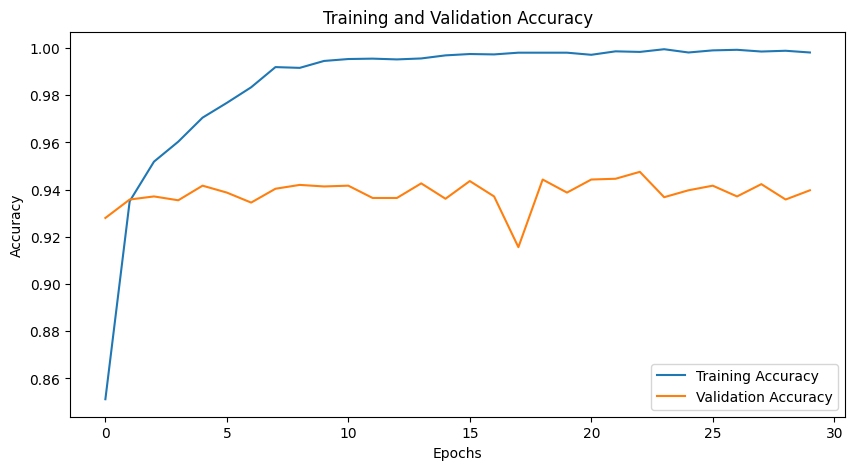

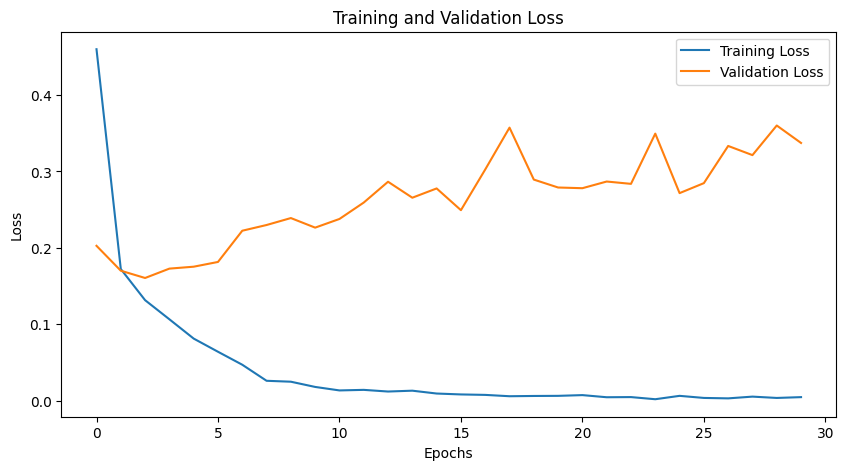

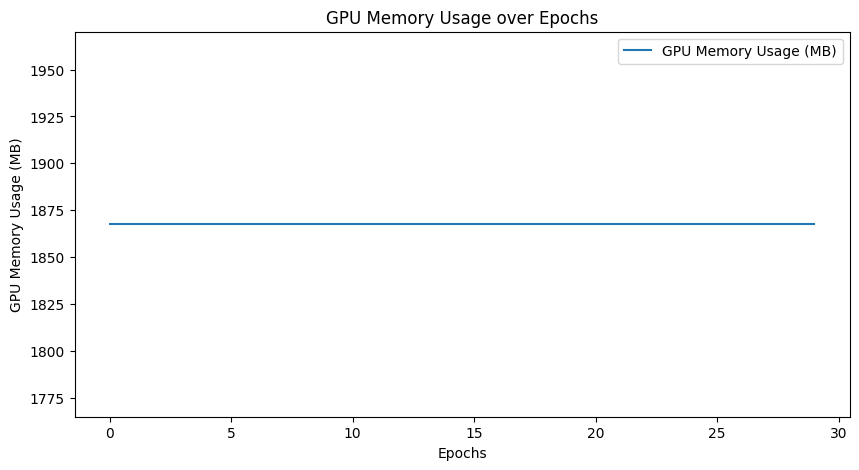

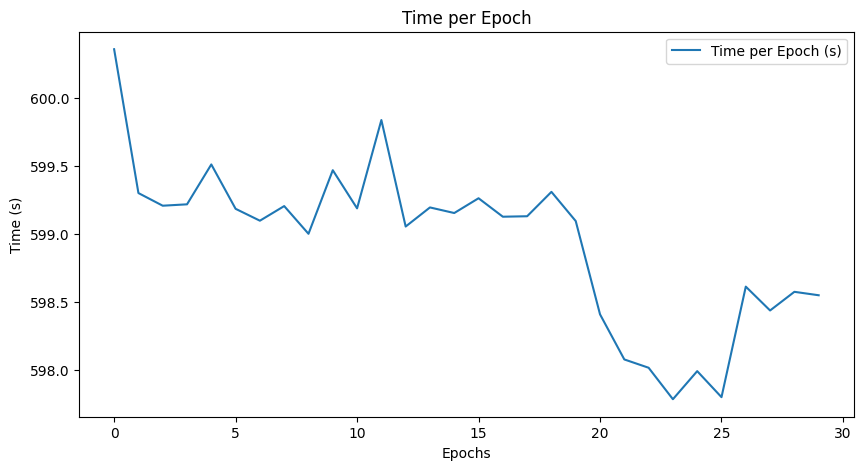

In [ ]:
# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot GPU Memory Usage per epoch
plt.figure(figsize=(10, 5))
plt.plot(gpu_memory_usage, label='GPU Memory Usage (MB)')
plt.xlabel('Epochs')
plt.ylabel('GPU Memory Usage (MB)')
plt.title('GPU Memory Usage over Epochs')
plt.legend()
plt.show()

# Plot time per epoch
plt.figure(figsize=(10, 5))
plt.plot(time_per_epoch, label='Time per Epoch (s)')
plt.xlabel('Epochs')
plt.ylabel('Time (s)')
plt.title('Time per Epoch')
plt.legend()
plt.show()

Classification Report:
                  precision    recall  f1-score   support

        HEATHLY       1.00      1.00      1.00      1007
MLN_1_and_MLN_2       0.98      0.99      0.99       783
          MSV_1       0.86      0.88      0.87       659
          MSV_2       0.88      0.84      0.86       621

       accuracy                           0.94      3070
      macro avg       0.93      0.93      0.93      3070
   weighted avg       0.94      0.94      0.94      3070



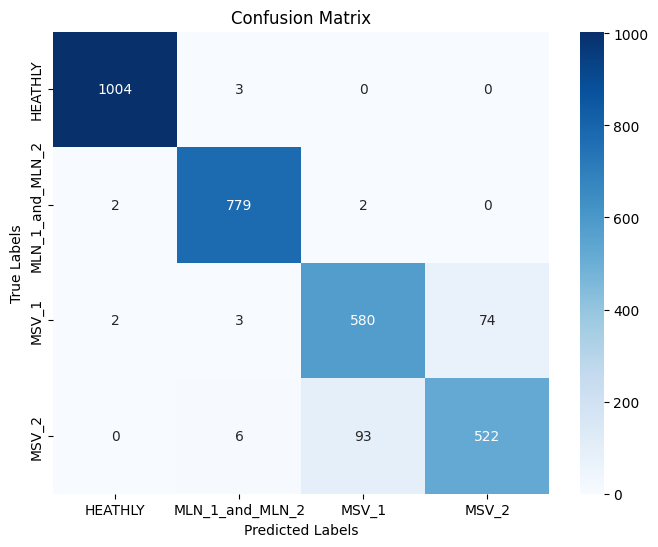

In [ ]:
# Classification report and confusion matrix on validation set
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
class_report = classification_report(all_labels, all_preds, target_names=dataset.classes)
print("Classification Report:\n", class_report)

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

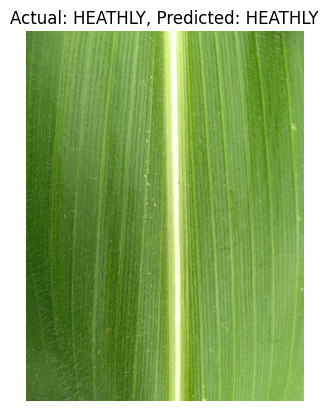

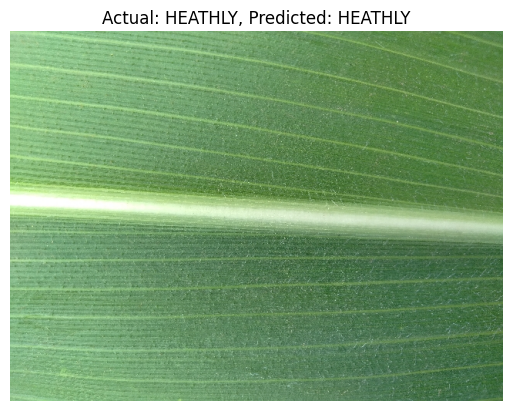

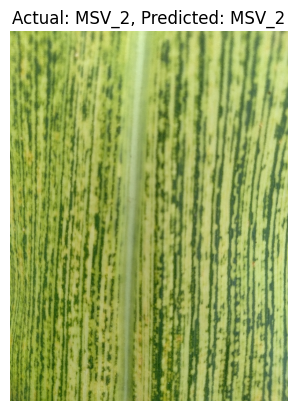

In [ ]:
import random
from PIL import Image
import matplotlib.pyplot as plt

# Function to display the image with predicted and actual labels
def display_image_with_prediction(image_path, actual_label, predicted_label):
    img = Image.open(image_path)
    plt.imshow(img)
    plt.title(f"Actual: {actual_label}, Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()

# Choose three random images from the validation dataset
samples = random.sample(val_dataset.indices, 3)

# Model must be in evaluation mode
model.eval()

for sample in samples:
    # Get the actual image path and label
    actual_img, actual_label = dataset.imgs[sample]
    actual_class = dataset.classes[actual_label]

    # Load and transform the image
    img = transform(Image.open(actual_img).convert("RGB")).unsqueeze(0).to(device)

    # Predict the class using the trained model
    with torch.no_grad():
        outputs = model(img)
        _, predicted_label = torch.max(outputs, 1)
        predicted_class = dataset.classes[predicted_label.item()]

    # Display the image with actual and predicted labels
    display_image_with_prediction(actual_img, actual_class, predicted_class)

Thank YOU!